# Plots for Example Crosson Instance

In [3]:
using QAOA, Distributions, Interpolations, LinearAlgebra, Arpack
using HDF5, Printf
using PythonPlot
PythonPlot.matplotlib.style.use("./paper.mplstyle")
PythonPlot.rc("axes", prop_cycle=PythonPlot.matplotlib.cycler(color=["#2D5FAA", "#B7293F", "#438E6A", "#F7BD2E", "#F16C37"]))

PATH = "/home/ubuntu/Archives/";
# PLOT_PATH = "/home/ubuntu/Archives/plots/SK_model/paper/";

In [4]:
using Revise, SpinFluctuations

┌ Warning: Error requiring `KrylovKit` from `LinearSolve`
│   exception =
│    LoadError: ArgumentError: Package LinearSolve does not have KrylovKit in its dependencies:
│    - You may have a partially installed environment. Try `Pkg.instantiate()`
│      to ensure all packages in the environment are installed.
│    - Or, if you have LinearSolve checked out for development and have
│      added KrylovKit as a dependency but haven't updated your primary
│      environment's manifest file, try `Pkg.resolve()`.
│    - Otherwise you may need to report an issue with LinearSolve
│    Stacktrace:
│      [1] macro expansion
│        @ ./loading.jl:1167 [inlined]
│      [2] macro expansion
│        @ ./lock.jl:223 [inlined]
│      [3] require(into::Module, mod::Symbol)
│        @ Base ./loading.jl:1144
│      [4] include(mod::Module, _path::String)
│        @ Base ./Base.jl:419
│      [5] include(x::String)
│        @ LinearSolve ~/.julia/packages/LinearSolve/qCLK7/src/LinearSolve.jl:1
│      [

In [5]:
Base.show(io::IO, f::Float64) = @printf(io, "%1.4f", f)

In [6]:
N = 10

J = [0.0 2.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 1.0;
    2.0 0.0 -1.0 0.0 2.0 1.0 1.0 0.0 0.0 0.0;
    1.0 -1.0 0.0 0.0 -2.0 0.0 0.0 -1.0 0.0 0.0;
    1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0;
    2.0 2.0 -2.0 0.0 0.0 1.0 1.0 1.0 0.0 1.0;
    1.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0;
    1.0 1.0 0.0 0.0 1.0 1.0 0.0 -1.0 0.0 0.0;
    1.0 0.0 -1.0 1.0 1.0 0.0 -1.0 0.0 0.0 0.0;
    1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
    1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0]

h = [5.0, -1.0, -5.0, 0.0, 0.0, -2.0, -1.0, -3.0, -1.0, -2.0]
mf_problem = Problem(0, h, J);

In [161]:
npts = 8192
coarse_times = range(0, 1, npts + 1);

## Exact gap

In [109]:
nev = 32
keep_EVs = 5
exact_times = range(0, 1, 33)
eigeninfo = map(s -> (eigs(-SpinFluctuations.hamiltonian(1 - s, s, mf_problem.local_fields, mf_problem.couplings), nev=nev, which=:LM, maxiter=10000)), exact_times)
λs = [vals[1] for vals in eigeninfo]

all_eigvecs = zeros(length(exact_times), 2^N, keep_EVs)
for k in 1:length(exact_times)
    sorting_perm = sortperm(λs[k])
    all_eigvecs[k, :, :] .= eigeninfo[k][2][:, sorting_perm[1:keep_EVs]]
end

In [110]:
λ = sort(reduce(hcat, λs), dims=1);

In [111]:
gap = λ[2, :] .- λ[1, :];
mingap = minimum(gap) 
mingap |> println
gap_idx = findfirst(x -> x == mingap, gap) 
gaploc = exact_times[gap_idx] 
gaploc |> println

0.0667
0.4062


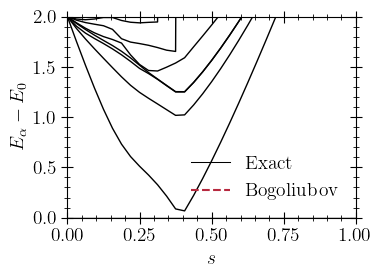

In [112]:
figure(figsize=(4, 3))
subplot(111)
for i in 1:size(λ)[1]
    # plot(exact_times[2:end], bogo_spec[i, :], "--C1", lw=1.5, alpha=1, ms=2)
    plot(exact_times, (λ[i, :] .- λ[1, :]), "-k", lw=1, alpha=1, ms=2)    
end
# axvline(gap_interval[1], c="C0")
# axvline(gap_interval[end], c="C0")
plot([], [], "-k", lw=0.75, label="Exact")
plot([], [], "--C1", lw=1.5, label="Bogoliubov")
xlim(0., 1.)
ylim(-0., 2)
xlabel("\$s\$")
ylabel("\$E_\\alpha - E_0\$")
legend(frameon=false)
tight_layout()
display(gcf())
PythonPlot.close();

### Eigenstates

In [113]:
H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem.local_fields, mf_problem.couplings)
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem.local_fields, mf_problem.couplings);

In [119]:
eigenstate(n) = [all_eigvecs[k, :, n] for k in 1:length(exact_times)]
eigenstates = [eigenstate(n) for n in 1:num_eig_vecs];
overlap(n, H) = [eigenstates[n][k]' * H * eigenstates[1][k] for k in 1:length(exact_times)]
frac_n(n) = abs.(overlap(n, H_z) .- overlap(n, H_x)) ./ (λ[n, :] .- λ[1, :]);
num_eig_vecs = size(all_eigvecs)[3]

5

In [120]:
gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)]

overlap_01_x = overlap(2, H_x)
overlap_01_z = overlap(2, H_z)

overlap_02_x = overlap(3, H_x)
overlap_02_z = overlap(3, H_z);

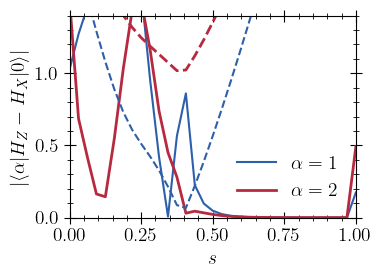

In [121]:
figure(figsize=(4, 3))
ax = subplot(111)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x) , label="\$\\alpha = 1\$")
plot(exact_times, abs.(overlap_02_z .- overlap_02_x) , label="\$\\alpha = 2\$", lw=2)
plot(exact_times, ((λ[2, :] .- λ[1, :])), "--C0")
plot(exact_times, ((λ[3, :] .- λ[1, :])), "--C1", lw=2)
xlim(0., 1.)
ylim(0, 1.4)
xlabel("\$s\$")
ylabel("\${|\\langle \\alpha|H_Z-H_X|0\\rangle|}\$")

legend(frameon=false)

tight_layout()
display(gcf())
PythonPlot.close();

## Mean-field trajectories

In [128]:
T_final = 32768.
tol = 1e-6;

In [137]:
schedule(t) = t / T_final
sol = evolve_mean_field(mf_problem.local_fields, mf_problem.couplings, T_final, schedule, rtol=tol, atol=tol) 

# get mean-field solution
solution = S -> sign.([S[3, i] for i in 1:size(S)[2]])
mf_sol = solution(sol(T_final)) 

10-element Vector{Float64}:
  1.0000
  1.0000
 -1.0000
  1.0000
  1.0000
  1.0000
  1.0000
 -1.0000
 -1.0000
 -1.0000

In [162]:
sol_t = sol.t

sol_u = zeros(length(sol.u), size(sol.u[1])...)
for i in 1:length(sol.u)
    sol_u[i, :, :] .= sol.u[i]
end

size(sol_u)

(520197, 3, 10)

### Bloch coordinates

In [163]:
nx_vals = n_vals("x", sol_u)
ny_vals = n_vals("y", sol_u)
nz_vals = n_vals("z", sol_u);

In [164]:
nx_coarse = n_coarse(nx_vals, sol_t, coarse_times)
ny_coarse = n_coarse(ny_vals, sol_t, coarse_times)
nz_coarse = n_coarse(nz_vals, sol_t, coarse_times);

In [165]:
S_vals = [transpose(reduce(hcat, [nx_coarse[:, k], ny_coarse[:, k], nz_coarse[:, k]])) |> Matrix for k in 1:npts+1]
magnetizations = reduce(hcat, map(S -> magnetization(S, mf_problem.local_fields, mf_problem.couplings), S_vals));

In [199]:
areas = Dict()
# dts = [(x[2] - x[1]) / T_final for x in zip(sol_t[1:end-1], sol_t[2:end])]
dts = [(x[2] - x[1]) / T_final for x in zip(coarse_times[1:end-1], coarse_times[2:end])]
for spin_idx in 1:N-1
    # areas[spin_idx] = sum(dts .* nz_vals[spin_idx, 2:end]) |> abs
    areas[spin_idx] = sum(dts .* magnetizations[spin_idx, 2:end]) |> abs
end

top_idxs = [k for (k, v) in sort(areas |> collect, by=x->x[2])]
top_idx = top_idxs[1]

9

In [200]:
regular_trajectories = filter!(x -> x != top_idx, collect(1:N-1));

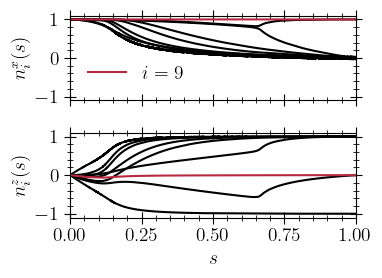

In [201]:
figure(figsize=(4, 3))

ax = subplot(211)
for spin_nr in regular_trajectories
    plot(coarse_times, nx_coarse[spin_nr, :], "-", c="k")    
end
plot(coarse_times, nx_coarse[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ax.set_xticklabels([])
ylim(-1.1, 1.1)
ylabel("\$n_i^x(s)\$")
legend(frameon=false, ncol=2)

ax = subplot(212)
for spin_nr in regular_trajectories
    plot(coarse_times, nz_coarse[spin_nr, :], "-", c="k")    
end
plot(coarse_times, nz_coarse[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ylim(-1.1, 1.1)
xlabel("\$s\$")
ylabel("\$n_i^z(s)\$")
# legend(frameon=false, ncol=2)

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

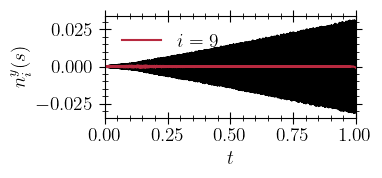

In [202]:
figure(figsize=(4, 2))


ax = subplot(111)
for spin_nr in regular_trajectories
    plot(coarse_times, ny_coarse[spin_nr, :], "-", c="k")    
end
plot(coarse_times, ny_coarse[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0.0, 1)
# ylim(-1e-3, 1e-3)
xlabel("\$t\$")
ylabel("\$n_i^y(s)\$")
legend(frameon=false)


tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

### Magnetization

In [203]:
function regularize(x; ε=1e-1)
    pv = x / (x^2 + ε^2)
    abs(x) < ε^2 ? pv : 1/x
end

regularize (generic function with 1 method)

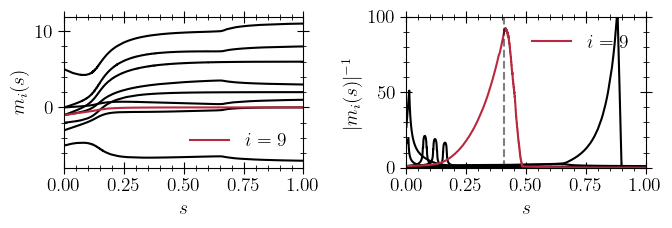

In [214]:
figure(figsize=(7, 2.5))


ax = subplot(121)
for spin_nr in regular_trajectories
    plot(coarse_times, magnetizations[spin_nr, :], "-", c="k")
end
plot(coarse_times, magnetizations[top_idx, :], "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0.0, 1)
# ylim(-1000,  1000)
xlabel("\$s\$")
ylabel("\$m_i(s)\$")
legend(frameon=false)

ax = subplot(122)
plot_func = x -> regularize.(x, ε=9e-2)
# plot_func = x -> x ./ (x.^2 .+ 1e-4)

for spin_nr in regular_trajectories
    # plot(coarse_times, plot_func(abs.(magnetizations[spin_nr, :])), "-", c="k")    
    plot(coarse_times, smoothen(plot_func(abs.(magnetizations[spin_nr, :])), coarse_times, navg=128), "-", c="k")
end
plot(coarse_times, smoothen(plot_func(abs.(magnetizations[top_idx, :])), coarse_times, navg=256), "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
# plot(coarse_times, plot_func(abs.(magnetizations[top_idx, :])), "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
axvline(gaploc, ls="--", c="k", alpha=0.5)
xlim(0.0, 1)
ylim(0, 100)
xlabel("\$s\$")
ylabel("\$|m_i(s)|^{-1}\$")
legend(frameon=false)


tight_layout()
display(gcf())
PythonPlot.close();

### Complex coordinates

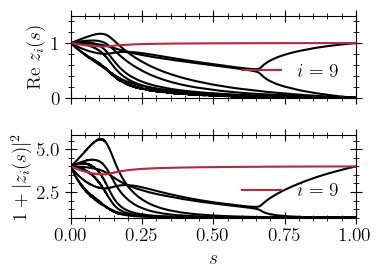

In [215]:
figure(figsize=(4, 3))

ax = subplot(211)
for spin_nr in regular_trajectories
    plot(coarse_times, complex_coordinate(spin_nr, nx_coarse, ny_coarse, nz_coarse) |> real, "-", c="k")    
end
plot(coarse_times, complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse) |> real, "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))
xlim(0, 1)
ylim(-0, 1.5) 
ax.set_xticklabels([])
# xlabel("\$s\$")
ylabel("\$\\mathrm{Re}\\; z_i(s)\$")
legend(frameon=false, ncol=2)

ax = subplot(212)
for spin_nr in regular_trajectories
    plot(coarse_times, (1 .+ abs.(complex_coordinate(spin_nr, nx_coarse, ny_coarse, nz_coarse)).^2).^2, "-", c="k")
end
plot(coarse_times, (1 .+ abs.(complex_coordinate(top_idx, nx_coarse, ny_coarse, nz_coarse)).^2).^2, "-", c="C1", label=@sprintf("\$i=%i\$", top_idx))

xlim(0, 1)
ylim(1, ) 
xlabel("\$s\$")
# ylabel("\$1 + [\\mathrm{Re}\\; z_i(s)]^2\$")
ylabel("\$1 +  |z_i(s)|^2\$")
legend(frameon=false, ncol=2)

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("mean_field_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

### Energies

In [156]:
# sigma_star = sign.(sol.u[end][3, :])
sigma_star = sign.(sol_u[end, 3, :])
h = mf_problem.local_fields
J = mf_problem.couplings
E = sum([-h[l] * sigma_star[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star[i] * sigma_star[j] for i in 1:N-1 for j in (i+1):N-1])

-22.0000

In [157]:
Int.(sigma_star) |> println

[1, 1, -1, 1, 1, 1, 1, -1, -1, -1]


In [158]:
[λ[k, :][end] for k in 1:6] |> println

[-26.0000, -22.0000, -22.0000, -22.0000, -22.0000, -22.0000]


In [159]:
for spin_idx in 1:N-1
    # sigma_star_flip = sign.(sol.u[end][3, :])
    sigma_star_flip = sign.(sol_u[end, 3, :])
    sigma_star_flip[spin_idx] = (-1) * sigma_star_flip[spin_idx]
    E_flip = sum([-h[l] * sigma_star_flip[l] for l in 1:N-1]) + sum([-J[i, j] * sigma_star_flip[i] * sigma_star_flip[j] for i in 1:N-1 for j in (i+1):N-1])
    println(spin_idx, ": ", E_flip)
end

1: -4.0000
2: -10.0000
3: -10.0000
4: -22.0000
5: -8.0000
6: -18.0000
7: -14.0000
8: -22.0000
9: -22.0000


In [160]:
println(top_idxs)

[9, 4, 8, 6, 7, 2, 5, 3, 1]


## Statistical Green function

In [181]:
tol = 1e-8
T_final = 32768.;
# T_final = 65536.;

In [182]:
lyapunov_parameters = LyapunovParameters(T_final, npts, tol, tol)
mf_sol, stat_GF = statistical_green_function(mf_problem, lyapunov_parameters)

flucs = k -> (real.(1.0im .* diag(stat_GF[k])[1:mf_problem.num_qubits]) .- 1.0) ./ 2;
all_flucs = reduce(hcat, map(flucs, 1:npts+1));

In [216]:
regular_trajectories = filter!(x -> x != top_idxs[1], collect(1:N-1));
# regular_trajectories = filter!(x -> x != top_idxs[2], regular_trajectories);

scale_factors = [1 .+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)).^2 for i in 1:N-1]
# mean_scaled_flucs = mean([scale_factors[i].^2 .* smoothen(all_flucs[i, :], coarse_times) for i in regular_trajectories], dims=1)[1];
mean_scaled_flucs = mean([smoothen(all_flucs[i, :], coarse_times) for i in regular_trajectories], dims=1)[1];

In [217]:
maximum(abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :])))

12.8948

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


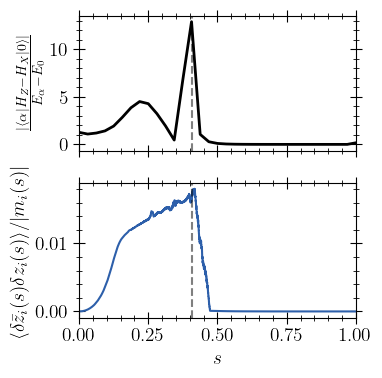

In [220]:
figure(figsize=(4, 4))
ax = subplot(211)
# semilogy(exact_times, abs.(overlap_01_z .- overlap_01_x) ./ ((λ[2, :] .- λ[1, :])), label="\$\\alpha = 1\$")
# plot(exact_times, abs.(overlap_02_z .- overlap_02_x) ./ ((λ[3, :] .- λ[1, :])), label="\$\\alpha = 2\$", lw=2)
plot(exact_times, frac_n(2) .+ frac_n(3), "-k", lw=2)
xlim(0., 1.)
# ylim(1e-1, 1e3)
ax.set_xticklabels([])
ylabel("\$\\frac{|\\langle \\alpha|H_Z-H_X|0\\rangle|}{E_\\alpha - E_0}\$")
axvline(gaploc, ls="--", c="k", alpha=0.5)

legend(frameon=false)

reg_func = x -> regularize.(x, ε=9e-2)
# inv_mag = smoothen(reg_func(abs.(magnetizations[top_idx, :])), coarse_times, navg=128)
inv_mag = reg_func(abs.(magnetizations[top_idx, :]))

subplot(212)
for i in 1:1#(N-1)÷2
    scale_factor = 1 .+ abs.(complex_coordinate(top_idxs[i], nx_coarse, ny_coarse, nz_coarse)).^2
    # plot(coarse_times, smoothen(all_flucs[top_idxs[i], :], coarse_times) .- mean_scaled_flucs)
    # plot(coarse_times, (smoothen(all_flucs[top_idxs[i], :], coarse_times) .- mean_scaled_flucs) .* inv_mag)
    
    # semilogy(coarse_times, smoothen(scale_factor.^2 .* all_flucs[top_idxs[i], :] .* inv_mag, coarse_times))
    plot(coarse_times, smoothen(scale_factor.^2 .* all_flucs[top_idxs[i], :] .* inv_mag, coarse_times))
end

axvline(gaploc, ls="--", c="k", alpha=0.5)
xlim(0, 1)
# ylim(1e-1, 1e2)
xlabel("\$s\$")
ylabel("\$ \\langle\\delta \\bar z_i(s) \\delta z_i(s) \\rangle / |m_i(s)|\$")

tight_layout()
display(gcf())
PythonPlot.close();

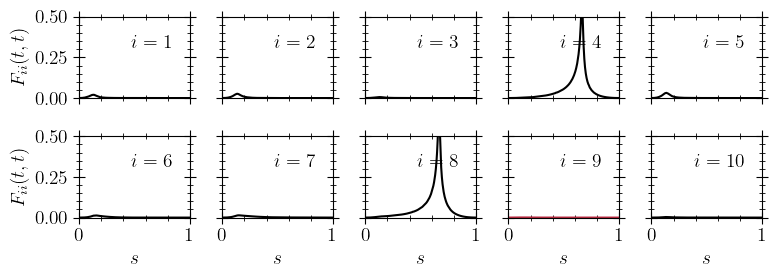

In [221]:
figure(figsize=(8, 3))
normalization = maximum(smoothen(all_flucs[top_idxs[1], :], coarse_times))
normalization = 1.
ylims = (0, maximum(all_flucs ./ normalization))
ylims = (0, 0.5)
for i in 1:N÷2
    ax = subplot(2, N÷2, i)
    c = "k"
    if i in top_idxs[1:1]
        c = "C1"
    end
    plot(coarse_times, smoothen(all_flucs[i, :], coarse_times) ./ normalization, label=@sprintf("\$i=%s\$", string(i)), c=c)
    xlim(0., 1.)
    ax.set_xticklabels([])
    ylim(ylims...)
    if i > 1
        ax.set_yticklabels([])
    end
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, N÷2, 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

for i in N÷2+1:N
    ax = subplot(2, N÷2, i)
    c = "k"
    if i in top_idxs[1:1]
        c = "C1"
    end
    plot(coarse_times, smoothen(all_flucs[i, :], coarse_times) ./ normalization, label=@sprintf("\$i=%s\$", string(i)), c=c)
    xlim(0., 1.)
    ylim(ylims...)
    if i > N÷2+1
        ax.set_yticklabels([])
    end    
    xlabel("\$s\$")    
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, N÷2, N÷2 + 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("fluctuations_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();

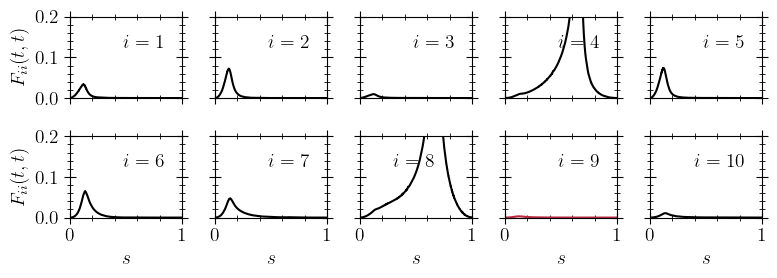

In [222]:
figure(figsize=(8, 3))
# normalization = maximum((1 .+ (nx_coarse[top_idxs[1], :] ./ (1 .+ sign(nz_coarse[top_idxs[1], end]) .* nz_coarse[top_idxs[1], :])).^2) .* (smoothen(all_flucs[top_idxs[1], :] .+ 0.0im, coarse_times) .|> sqrt |> real))
normalization = 1.
ylims = (0, 0.2)

for i in 1:N÷2
    ax = subplot(2, N÷2, i)
    c = "k"
    if i in top_idxs[1:1]
        c = "C1"
    end
    scale_factor = 1 .+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)).^2
    plot(coarse_times, scale_factor.^2 .* smoothen(all_flucs[i, :], coarse_times), label=@sprintf("\$i=%s\$", string(i)), c=c)
    # plot(coarse_times, (scale_factor / normalization) .* (smoothen(all_flucs[i, :] .+ 0.0im, coarse_times) .|> sqrt |> real), label=@sprintf("\$i=%s\$", string(i)), c=c)
    # plot(coarse_times, smoothen(scale_factor .* real(sqrt.(all_flucs[i, :] .+ 0.0im)), coarse_times), label=@sprintf("\$i=%s\$", string(i)), c=c)
    xlim(0., 1.)
    ax.set_xticklabels([])
    ylim(ylims...)
    if i > 1
        ax.set_yticklabels([])
    end
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, N÷2, 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

for i in N÷2+1:N
    ax = subplot(2, N÷2, i)
    c = "k"
    if i in top_idxs[1:1]
        c = "C1"
    end
    scale_factor = 1 .+ abs.(complex_coordinate(i, nx_coarse, ny_coarse, nz_coarse)).^2
    plot(coarse_times, scale_factor.^2 .* smoothen(all_flucs[i, :], coarse_times), label=@sprintf("\$i=%s\$", string(i)), c=c)
    # plot(coarse_times, (scale_factor / normalization) .*  (smoothen(all_flucs[i, :] .+ 0.0im, coarse_times) .|> sqrt |> real), label=@sprintf("\$i=%s\$", string(i)), c=c)
    # plot(coarse_times, smoothen(scale_factor .* real(sqrt.(all_flucs[i, :] .+ 0.0im)), coarse_times), label=@sprintf("\$i=%s\$", string(i)), c=c)
    xlim(0., 1.)
    ylim(ylims...)
    if i > N÷2+1
        ax.set_yticklabels([])
    end    
    xlabel("\$s\$")    
    legend(frameon=false, ncol=2, handlelength=0)
end

ax = subplot(2, N÷2, N÷2 + 1)
ax.set_ylabel("\$F_{ii}(t, t)\$")

tight_layout()
display(gcf())
# savefig("../plots/" * @sprintf("fluctuations_max2sat_typical_instance_%04i_from_arxiv_2206_06876_N_%i_num_clauses_%i.pdf", idx, N, num_clauses), dpi=256, bbox_inches="tight")
PythonPlot.close();